Smallest version of GPT-2 model,  with 124 million parameters, as described in Radford's et al.'s paper, "Language Models are Unsupervised Multitask Learners."

In [39]:
#Configuration of the model
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "ctx_len": 1024, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}


Components of the models architecture:
- Layer normalization
- GELU activation
- Feed forward network
- Shortcut connections
- Transformer block

In [3]:
#First, we build the backbone of the model. The configuration is passed through a dictionary. The forward method describes the data flow through the model: 
#it computes token and #positional embeddings for the input indices, applies dropout, processes the data through #the transformer blocks, 
#applies normalization, and finally produces logits with the linear output layer
import torch.nn as nn
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])# Placeholder for Transformer block
        self.final_norm = DummyLayerNorm(cfg["emb_dim"]) #Placeholder for LayerNorm 
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
        
class DummyTransformerBlock(nn.Module): #Placeholder transformer class
        def _
    _init__(self, cfg):
            super().__init__()
        def forward(self, x): 
            return x
            
class DummyLayerNorm(nn.Module): #Placehoder fot Layer Normalization
        def __init__(self, normalized_shape, eps=1e-5): 
            super().__init__()
        def forward(self, x):
            return x

In [1]:
#Generating input
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
#Initialiting and feeding the batch to the dummy model
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)


Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


***Layer Normalization***

The main idea behind layer normalization is to adjust the activations (outputs) of a neural network layer to have a mean of 0 and a variance of 1, also known as unit variance. This adjustment speeds up the convergence to effective weights and ensures consistent, reliable training. It is applied before and after the multi-head attention module and before the final output layer.


In [7]:
#Example of a neural network with 5 inputs and 6 outputs
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #2 training examples with 5 dimensions
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
#Checking the mean and variance
mean = out.mean(dim=-1, keepdim=True)#-1 refers to the last dimension of the tensoer. In this case equals to dim=1
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [9]:
#Applying layer normalization:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)


Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [5.9605e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
#Turning off scientific notation
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)



Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [11]:
#Creating norrmalization module. Scale and shifting are trainable parameters automatically adjusted during training.
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 #to prevent division by zero during normalization. 
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)#unbiased False does not apply Bessel's correction, following the original GPT-2 implementation
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [12]:
#Applying the layer normalization to an example
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)


Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


***GELU activation***

Implementing GELU approximation

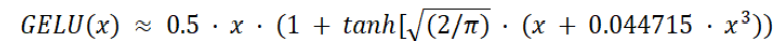

In [14]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))
    ))

In [16]:
#Creating a feed forward module which uses GELU function
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),GELU(),nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        nn.Dropout(cfg["drop_rate"]))
    def forward(self, x):
        return self.layers(x)


In [17]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


***Shortcut connections***

Shorcut connections are used to mitigate the challenge of vanishing gradients. Shortcut connections involve adding the inputs of a layer to its
outputs, effectively creating an alternate path that bypasses certain layers. 

In [22]:
#Code of shortcut connection
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
        # Implement 5 layers
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),GELU())
        ])
    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.size() == layer_output.size():
                x = x + layer_output
            else:
                x = layer_output
        return x

In [23]:
#Example without shortcuts
layer_sizes = [3, 3, 3, 3, 3, 1] #each layer will be initialized such that it accepts an example with 3 input values and returns 3 output values. The last layer returns a single output value:
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights forreproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [24]:
#Function to compute the grdient's in the backward pass
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])
    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    # Backward pass to calculate the gradients
    loss.backward()
    
    for name, param in model.named_parameters(): #n iterate through the weight parameters 
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [25]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


The gradients become smaller as we progress from the last layer (layers.4) to the first layer (layers.0),

In [26]:
#Model with skip connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


The gradient value stabilizes as we progress towards the first layer (layers.0) and doesn't shrink to a vanishingly small value.

***Transformer block***

Transformer block connects the components above: multi-head attention, layer normalization, dropout, feed forward layers, and GELU activations. 

In [51]:
from Classes import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["ctx_len"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])
    
    def forward(self, x):
   
        shortcut = x       #Shortcut connection for attention block
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut #Add the original input back
        
        shortcut = x #Shortcut connection for feed forward block
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut #Add the original input back

        return x


In [52]:
#Instantiating a transformer block
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


***Coding the GPT model***

Tokenized text is first converted into token embeddings, which are then augmented with positional embeddings. This combined information forms a tensor that is passed through a series of transformer blocks shown in the center (each containing multi-head attention and feed forward neural network layers with dropout and layer normalization), which are stacked on top of each other and repeated 12 times. The output from the final transformer block goes through a final layer normalization step before reaching the linear output layer. This layer maps the transformer's output to a high-dimensional space (in this case, 50,257 dimensions, corresponding to the model's vocabulary size) to predict the next token in the sequence.

In [53]:
import torch.nn as nn
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"]) 
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x = tok_embeds + pos_embeds
    
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [54]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.3836,  0.1907, -0.2999,  ...,  0.0701, -0.3504, -0.8911],
         [ 0.3457, -0.4659, -0.7705,  ..., -0.3331,  0.0161,  0.1663],
         [ 0.9492, -0.1808, -0.0225,  ...,  0.2096, -0.3042, -0.1051],
         [-0.8163,  0.3850, -0.2297,  ...,  1.0137,  0.4000, -0.4916]],

        [[ 0.0851,  0.1240, -0.0751,  ...,  0.5713,  0.2818, -0.6030],
         [ 0.0400, -0.2573,  0.0609,  ...,  0.5641, -0.1687,  0.3409],
         [ 0.9161,  1.0140, -0.2341,  ...,  0.2165,  0.5243,  0.1291],
         [ 0.1589,  0.2120,  0.6350,  ...,  0.9529, -0.1897, -0.3581]]],
       grad_fn=<UnsafeViewBackward0>)


The last dimension, 50,257, corresponds to the vocabulary size of the tokenizer.

In [ ]:
#numel() method, short for "number of elements," to collect the total number of parameters in the model's parameter tensors

In [55]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")


Total number of parameters: 163,009,536


***Generating text***

Code that converts the tensor outputs of the GPT model back into text. Thisincludes decoding the output tensors, selecting tokens based on a probability distribution, and converting these tokens into human-readable text.


In [56]:
#Simple implementation of a generative loop for a language model
def generate_text_simple(model, idx, max_new_tokens, context_size): #idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:] #Crop current context if it exceeds the supported context size
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :] #Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1) #probas has shape (batch, vocab_size)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) #idx_next has shape (batch, 1)
        idx = torch.cat((idx, idx_next), dim=1) # (batch, n_tokens+1) #Append sampled index to the running sequence
    return idx


In [65]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #Adding a batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [73]:
#mode evaldisables random components like dropout, which are only used during training
model.eval() 
out = generate_text_simple(model=model, idx=encoded_tensor,max_new_tokens=6,context_size=GPT_CONFIG_124M["ctx_len"])
print("Output:", out)
print("Output length:", len(out[0]))


Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [74]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


The model is untrained which expalins hence the random output text above